In [1]:
import os
import requests
import tensorflow_addons as tfa
import tensorflow as tf
from tensorflow import keras
import matplotlib.pylab as plt
import matplotlib.cm as cm
import numpy as np

2022-06-27 22:51:14.509487: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudart.so.11.0


In [2]:
# Load a pre-trained model
if not os.path.exists('models/model_1536_F1_095.h5'):
    print("Downloading model...")
    file = requests.get("https://drive.google.com/uc?export=download&confirm=9_s_&id=1ErwopTT8ZKx-L9BspS5n1ATP4Za2K6Nh")
    open('models/model_1536_F1_095.h5', 'wb').write(file.content)
    print("Done.")

Done.


In [3]:
model = tf.keras.models.load_model('models/model_1536_F1_095.h5', custom_objects={'AdamW': tfa.optimizers.AdamW})
model.summary()

2022-06-27 22:51:17.156476: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcuda.so.1
2022-06-27 22:51:17.210534: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-06-27 22:51:17.211037: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1733] Found device 0 with properties: 
pciBusID: 0000:08:00.0 name: NVIDIA GeForce RTX 3090 computeCapability: 8.6
coreClock: 1.845GHz coreCount: 82 deviceMemorySize: 23.70GiB deviceMemoryBandwidth: 871.81GiB/s
2022-06-27 22:51:17.211050: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudart.so.11.0
2022-06-27 22:51:17.212716: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcublas.so.11
2022-06-27 22:51:17.212737: I tensorflow/stream_executor/pl

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 1536, 1536,  0                                            
__________________________________________________________________________________________________
Augment_and_Crop_and_Rescale (S (None, 1024, 1024, 3 0           input_1[0][0]                    
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 512, 512, 8)  224         Augment_and_Crop_and_Rescale[0][0
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 512, 512, 8)  32          conv2d[0][0]                     
______________________________________________________________________________________________

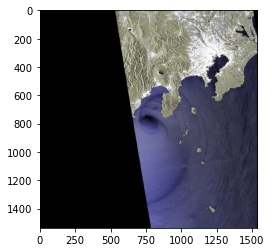

2022-06-27 22:51:18.514359: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:176] None of the MLIR Optimization Passes are enabled (registered 2)
2022-06-27 22:51:18.530930: I tensorflow/core/platform/profile_utils/cpu_utils.cc:114] CPU Frequency: 3692830000 Hz
2022-06-27 22:51:18.740859: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudnn.so.8
2022-06-27 22:51:19.076829: I tensorflow/stream_executor/cuda/cuda_dnn.cc:359] Loaded cuDNN version 8100
2022-06-27 22:51:19.457880: W tensorflow/stream_executor/gpu/asm_compiler.cc:191] Falling back to the CUDA driver for PTX compilation; ptxas does not support CC 8.6
2022-06-27 22:51:19.457898: W tensorflow/stream_executor/gpu/asm_compiler.cc:194] Used ptxas at ptxas
2022-06-27 22:51:19.457981: W tensorflow/stream_executor/gpu/redzone_allocator.cc:314] Unimplemented: ptxas ptxas too old. Falling back to the driver to compile.
Relying on driver to perform ptx compilation. 
Modif

Class prediction:  [0.02361538 0.9763846 ]


2022-06-27 22:51:19.871499: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcublasLt.so.11
2022-06-27 22:51:19.953108: I tensorflow/stream_executor/cuda/cuda_blas.cc:1838] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


In [4]:
# Load image to test
path = "data/test/pos/"
img_name = "cffe42_20191012T084028_20191012T084212_mos_rgb.png"

img = keras.preprocessing.image.load_img(
    path + img_name, 
    target_size=(1536, 1536)
)
img_array = keras.preprocessing.image.img_to_array(img)
img_array = tf.expand_dims(img_array, 0)  # Create batch axis

plt.imshow(img)
plt.show()
preds = model.predict(img_array)
print("Predicted class: ", preds[0])

/home/filippo/anaconda3/envs/tf2py37/lib/python3.7/site-packages/tensorflow/python/keras/backend.py:435: UserWarning: `tf.keras.backend.set_learning_phase` is deprecated and will be removed after 2020-10-11. To update it, simply pass a True/False value to the `training` argument of the `__call__` method of your layer or model.
  warnings.warn('`tf.keras.backend.set_learning_phase` is deprecated and '


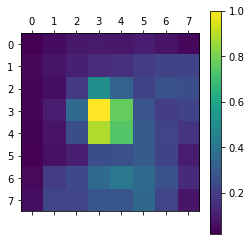

In [5]:
def make_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index=None):
    # First, we create a model that maps the input image to the activations
    # of the last conv layer as well as the output predictions
    grad_model = tf.keras.models.Model(
        [model.inputs], [model.get_layer(last_conv_layer_name).output, model.output]
    )

    # Then, we compute the gradient of the top predicted class for our input image
    # with respect to the activations of the last conv layer
    with tf.GradientTape() as tape:
        # Since the model has Dropout and image augmentation layers, 
        # we need to disable them to compute the gradients by setting training=False
        last_conv_layer_output, preds = grad_model(img_array, training=False)
        if pred_index is None:
            pred_index = tf.argmax(preds[0])
            print("pred_index: ", pred_index)
        class_channel = preds[:, pred_index]

    # This is the gradient of the output neuron (top predicted or chosen)
    # with regard to the output feature map of the last conv layer
    grads = tape.gradient(class_channel, last_conv_layer_output)

    # This is a vector where each entry is the mean intensity of the gradient
    # over a specific feature map channel
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2)) # probably each feature in the 8x8 grid has the same value and it would have been enough to take just 1 slice rather than the mean.

    # We multiply each channel in the feature map array
    # by "how important this channel is" with regard to the top predicted class
    # then sum all the channels to obtain the heatmap class activation
    last_conv_layer_output = last_conv_layer_output[0]
    heatmap = last_conv_layer_output @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)

    # For visualization purpose, we normalize the heatmap between 0 & 1
    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    return heatmap.numpy()

# Remove last layer's activation (softmax or sigmoid)
model.layers[-1].activation = None

# Since the model has Dropout and image augmentation layers, we need to disable them to compute the gradients by setting training=False
tf.keras.backend.set_learning_phase(0)

last_conv_layer_name = 'activation_14' # This is for the HR model
heatmap = make_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index=1)

plt.matshow(heatmap)
plt.colorbar()
plt.show()

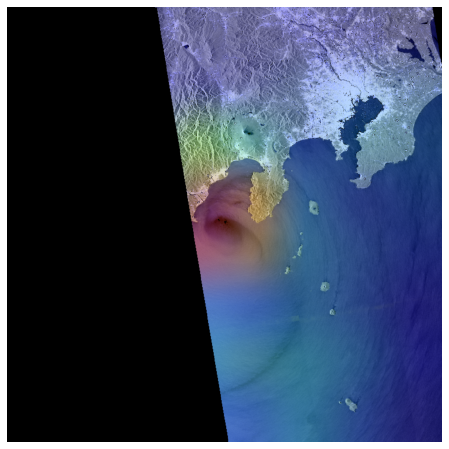

In [6]:
def display_gradcam(img, heatmap, cam_path="cam.jpg", alpha=0.4):
    
    # Rescale heatmap to a range 0-255
    heatmap = np.uint8(255 * heatmap)

    # Use jet colormap to colorize heatmap
    jet = cm.get_cmap("jet")

    # Use RGB values of the colormap
    jet_colors = jet(np.arange(256))[:, :3]
    jet_heatmap = jet_colors[heatmap]

    # Create an image with RGB colorized heatmap
    jet_heatmap = tf.keras.preprocessing.image.array_to_img(jet_heatmap)
    jet_heatmap = jet_heatmap.resize((img.shape[1], img.shape[0]))
    jet_heatmap = tf.keras.preprocessing.image.img_to_array(jet_heatmap)

    jet_heatmap[img==0] = 0
    
    # Superimpose the heatmap on original image
    superimposed_img = jet_heatmap*0.4 + img 
    superimposed_img = tf.keras.preprocessing.image.array_to_img(superimposed_img)

    # Display Grad CAM
    fig, ax = plt.subplots(figsize=(8,8))
    plt.imshow(superimposed_img)
    ax.axis("off")
    plt.show()

numpy_img = np.uint8(img_array[0].numpy())
display_gradcam(numpy_img, heatmap)